In [67]:
# Load packages
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
path = 'C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports_SP'

# Set path to be the directory:
os.chdir(path)

In [69]:
#df = pd.concat([pd.read_csv(f, usecols=['Reporting Period End Date', 'IDRSSD', 'var_name', 'value']) for f in os.listdir() if f.endswith('.csv')])

# list of var_names:
#list = ['RIADA517', 'RIADA518', 'RIAD4508', 'RIAD0093', 'RIADHK03', 'RIADHK04', 'RCON6636']

# create a subset of df with only the var_names in the list:
#df2 = df[df['var_name'].isin(list)]
#df2.to_csv('C:/Users/angel/Documents/Economics/Research/Banking Project/data/intermediate/call_reports/call_reports.csv', index = False)

In [70]:
# Read file that contains only the variables of interest, specify that the column 'date' is a date:
df = pd.read_csv('call_reports.csv', low_memory=False)

In [71]:
# Create a new column that will contain the deposit expenditure it will sum 'RIADA517', 'RIADA518', 'RIAD4508', 'RIAD0093' for
# any date before 2017:
df['Deposit Expenditure'] = np.where(df['Date'] < '2017-01-01', df['RIADA517']+df['RIADA518']+df['RIAD4508']+df['RIAD0093'], 
                                     df['RIADHK03']+df['RIADHK04']+df['RIAD4508']+df['RIAD0093'])

In [72]:
df['Total Deposit'] = np.where(df['Date'] < '2017-01-01', df['RCON3485']+df['RCONB563']+df['RCONA514']+df['RCONA529'], 
                                     df['RCON3485']+df['RCONB563']+df['RCONHK16']+df['RCONHK17'])

In [73]:
df['Deposit Rate'] = df['Deposit Expenditure'] / df['Total Deposit']

In [74]:
# Drop observations with Total Deposit equal to zero:
df = df[df['Total Deposit'] != 0]

In [75]:
# Create a column with the avg. depoit rate and std per Date:
df['Avg. Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform('mean')
df['Std. Deposit Rate'] = df.groupby('Date')['Deposit Rate'].transform('std')

In [76]:
df['Normalized Deposit Rate'] = (df['Deposit Rate'] - df['Avg. Deposit Rate']) / df['Std. Deposit Rate']

In [77]:
# Drop the top and bottom 1% deposit rates for each date:
df2 = df.groupby('Date').apply(lambda x: x[(x['Normalized Deposit Rate'] > x['Normalized Deposit Rate'].quantile(0.01)) & 
                                          (x['Normalized Deposit Rate'] < x['Normalized Deposit Rate'].quantile(0.99))])

C:\Users\angel\AppData\Local\Temp\ipykernel_18312\1786796680.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df2 = df.groupby('Date').apply(lambda x: x[(x['Normalized Deposit Rate'] > x['Normalized Deposit Rate'].quantile(0.01)) &


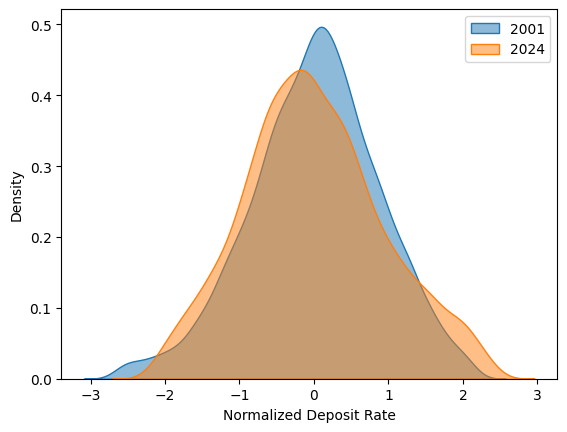

In [78]:
# Use df2 to plot filled Kernel distributions for the normalized deposit rate for the first and last date:
sns.kdeplot(df2[df2['Date'] == df2['Date'].min()]['Normalized Deposit Rate'], label = '2001', fill=True, alpha = 0.5)
sns.kdeplot(df2[df2['Date'] == df2['Date'].max()]['Normalized Deposit Rate'], label = '2024', fill=True, alpha = 0.5)
plt.legend()
plt.show()

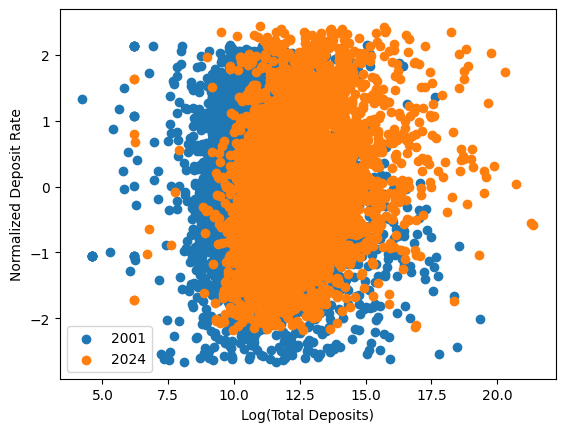

In [82]:
# plot a scatter with the normalized deposit rate and log(Total Deposits)for the first and last date:
plt.scatter(np.log(df2[df2['Date'] == df2['Date'].min()]['Total Deposit']), df2[df2['Date'] == df2['Date'].min()]['Normalized Deposit Rate'], label = '2001')
plt.scatter(np.log(df2[df2['Date'] == df2['Date'].max()]['Total Deposit']), df2[df2['Date'] == df2['Date'].max()]['Normalized Deposit Rate'], label = '2024')
plt.legend()
plt.ylabel('Normalized Deposit Rate')
plt.xlabel('Log(Total Deposits)')
plt.show()